In [1]:
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow


import torch
import torchvision
import torchvision.transforms.v2 as T2
from torch.utils.data import DataLoader, Dataset, Subset

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"running on {device}")

running on cpu


In [2]:
images_path = Path("/kaggle/input/face-images-with-marked-landmark-points/face_images.npz")
keypoints_path = Path("/kaggle/input/face-images-with-marked-landmark-points/facial_keypoints.csv")

In [3]:
images = np.load(images_path) 
images = images[images.files[0]] # get the data
images = np.moveaxis(images, -1, 0)  # move the last index to the first, changes (96,96,7049) -> (7049, 96, 96)
images = images.reshape(images.shape[0], images.shape[1], images.shape[2], 1) # add color channel (7049, 1, 96, 96)
images.shape

<ipython-input-3-b6bbf95d303a>:2: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  images = images[images.files[0]] # get the data


(7049, 96, 96, 1)

In [4]:
type(images[0])

numpy.ndarray

### plot random images

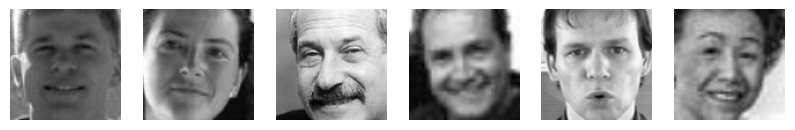

In [5]:
def plot (img:np.ndarray, ax):
    ax.imshow(img, cmap="gray") 
    ax.axis(False)

no_images = 6
samples = torch.randperm(len(images))[:no_images]

fig, axs = plt.subplots(nrows=1, ncols=no_images, figsize=(10,5))
for i in range(len(samples)):
    plot(images[samples[i]], ax=axs[i])

### get landmarks


In [6]:
landmarks_df = pd.read_csv(keypoints_path)
landmarks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

In [7]:
# replace NaN's with 0
landmarks_df.fillna(value=0, inplace=True)
landmarks_df

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7044,67.402546,31.842551,29.746749,38.632942,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,48.265961,67.029093,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.426637,79.683921
7045,66.134400,38.365501,30.478626,39.950198,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,47.910346,66.626011,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.287397,77.983023
7046,66.690732,36.845221,31.666420,39.685042,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,49.462572,67.515161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,49.462572,78.117120
7047,70.965082,39.853666,30.543285,40.772339,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,50.754202,66.724988,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.065186,79.586447


In [8]:
landmarks = np.array(landmarks_df.values)
landmarks[0]

array([66.03356391, 39.00227368, 30.22700752, 36.4216782 , 59.58207519,
       39.64742256, 73.13034586, 39.96999699, 36.35657143, 37.3894015 ,
       23.45287218, 37.3894015 , 56.95326316, 29.03364812, 80.22712782,
       32.22813835, 40.22760902, 29.0023218 , 16.35637895, 29.64747068,
       44.42057143, 57.06680301, 61.19530827, 79.97016541, 28.61449624,
       77.38899248, 43.3126015 , 72.93545865, 43.13070677, 84.48577444])

In [9]:
def pair_landmarks(landmarks):
    pairs = []
    idx = 0
    while idx < len(landmarks):
        pair = landmarks[idx:idx+2]
        pair = [int(coord) for coord in pair]
        pairs.append(pair)
        idx += 2
    return pairs
    
def draw_landmark_on_image(img, landmark):
    pairs = pair_landmarks(landmark)
    for pair in pairs:
        img = cv2.circle(img.astype(np.uint8), pair, 1, (255,255,255), 1)
    return cv2_imshow(img)

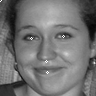

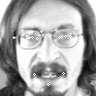

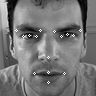

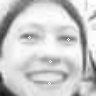

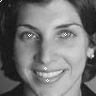

In [10]:
no_images = 5
samples = torch.randperm(len(images))[:no_images]
for i in range(len(samples)):
    axs[i] = draw_landmark_on_image(images[samples[i]], landmarks[samples[i]])

### dataset

In [11]:
class LandmarkDataset(Dataset):
    def __init__ (self, images_dir, landmarks_dir, transforms=None):
        super(LandmarkDataset).__init__()
        self.images = self.load_images(images_dir)
        self.landmarks = self.load_landmarks(landmarks_dir)
        self.transforms = transforms

    def load_images(self, images_dir):
        images = np.load(images_dir) 
        images = images[images.files[0]] # get the data
        images = np.moveaxis(images, -1, 0)  # move the last index to the first, changes (96,96,7049) -> (7049, 96, 96)
        images = images.reshape(images.shape[0], images.shape[1], images.shape[2], 1) # add color channel (7049, 1, 96, 96)
        return images

    def load_landmarks(self, landmarks_dir):
        landmarks_df = pd.read_csv(landmarks_dir)
        landmarks_df.fillna(value=0, inplace=True)
        landmarks = np.array(landmarks_df.values)
        return landmarks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.tensor(self.images[idx]).permute(2,0,1)
        landmarks = torch.tensor(self.landmarks[idx])

        if self.transforms:
            image_trans = self.transforms(image)
            return image, landmarks
            
        return image, landmarks
        

In [12]:
dataset = LandmarkDataset(images_path, keypoints_path)

samples = torch.randperm(len(dataset))
train_size = int(0.7 * len(dataset))

train_dataset = Subset(dataset, samples[:train_size])
test_dataset = Subset(dataset, samples[train_size:])

BATCH_SIZE =32
train_dataloader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, BATCH_SIZE)


print(len(train_dataset), len(test_dataset))
print(len(train_dataloader), len(test_dataloader))


<ipython-input-11-c7f6f446c762>:10: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  images = images[images.files[0]] # get the data


4934 2115
155 67


In [13]:
samples

tensor([5011, 3233, 4085,  ..., 3100, 5315, 4347])